In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.cluster import KMeans
from scipy import ndimage
from scipy.spatial import distance

**Importing data from drive**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Taking all images from drive **

In [ ]:
# return a dictionary that holds all images category by category. 
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for cat in os.listdir(path):
            img = cv2.imread(path + "/" + cat,0)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if img is not None:
                category.append(img)
        images[filename] = category
    return images
# take all images category by category
images = load_images_from_folder('/content/drive/MyDrive/CS67_Fall2022_ A1_Dataset/Training')   
# take test images
test = load_images_from_folder("/content/drive/MyDrive/CS67_Fall2022_ A1_Dataset/Test") 

**Using SIFT descriptor**

In [29]:
# Creates descriptors using sift, it takes one parameter that is images dictionary and return an array whose first index holds 
# the decriptor_list without an order and the second index holds the sift_vectors dictionary which holds the descriptors
def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift_detector = cv2.xfeatures2d.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            kp, des = sift_detector.detectAndCompute(img,None)
           
            
            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

sifts = sift_features(images) 
# Taking unordered descriptor list
descriptor_list = sifts[0] 
# Takeing sift features which are seperated class by class for training data
all_bovw_feature = sifts[1] 
# Takeing sift features which are seperated class by class for test data
test_bovw_feature = sift_features(test)[1] 


**Unsupervised (Applying k means clustering and ploting histogram)**

(array([[136.,  69.,  24., ...,   0.,   0.,   0.],
        [176.,  47.,   9., ...,   0.,   0.,   0.],
        [194.,  30.,  13., ...,   0.,   0.,   0.],
        ...,
        [195.,  36.,  11., ...,   0.,   0.,   0.],
        [215.,  21.,   6., ...,   0.,   0.,   0.],
        [211.,  24.,   5., ...,   0.,   0.,   0.]]),
 array([1.06581410e-14, 1.88741456e+01, 3.77482912e+01, 5.66224368e+01,
        7.54965825e+01, 9.43707281e+01, 1.13244874e+02, 1.32119019e+02,
        1.50993165e+02, 1.69867311e+02, 1.88741456e+02]),
 <a list of 128 Lists of Patches objects>)

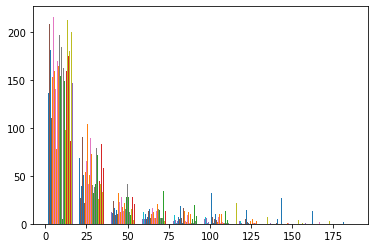

In [41]:
# K-means clustering algorithm takes two arguments one is number of clusters k and other is descriptors list 
# IT returns an array which holds central points
def K_Means(k, descriptor_list):
    K_Means = KMeans(n_clusters = k, n_init=10)
    K_Means.fit(descriptor_list)
    Visual_Words = K_Means.cluster_centers_ 
    return Visual_Words
    
# It takes visual words which are central points    
Visual_Words = K_Means(250, descriptor_list) 
plt.hist(Visual_Words)

**Creating a function for histogram**

In [42]:
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

In [43]:
# Our defined function takes two arguments.The first argument is a dictionary that holds the descriptors and the second parameter is an 
# array that holds the central points. It returns a dictionary with histograms of aimages. 
def img_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    
# Creating histograms for train data    
bovw_train = img_class(all_bovw_feature, Visual_Words) 
# Creating histograms for test data
bovw_test = img_class(test_bovw_feature, Visual_Words)

**Supervised (K nearest neighbour)**

In [44]:
# I used only 1 nearest neighbour which takes 2 arguments (feature vectors of training and test images)
# The defined function returns an array that holds the number of test images, number of correctly predicted images and records of class based images respectively
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    
# Call the knn function    
results_bowl = knn(bovw_train, bovw_test) 

**Defining and calculating accuracy**

In [45]:
# Now we will define a function that calculates average accuaracy.  
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))
        
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl) 

Average accuracy: %58.5

Class based accuracies: 

00002 : %90.0
00008 : %80.0
00004 : %65.0
00006 : %50.0
00003 : %50.0
00001 : %45.0
00007 : %30.0
00005 : %50.0
00009 : %65.0
00010 : %60.0
